#MSM of the alanine dipeptide
Here we run through most of the things that can be done with this package using a simple two-state model. There are more sophisticated examples that enable for further possibilities. 
First we import a number of libraries we will need as we run this example

In [1]:
%load_ext autoreload
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

###Discretizing the trajectory
We start loading the simulation data using the `trajectory` module. For this we use the external library [`MDtraj`](http://mdtraj.org), which contains all sorts of methods for parsing and calculating interestign properties of our time-series data.

In [2]:
import mdtraj as md
from mastermsm.trajectory import traj

In [3]:
tr = traj.TimeSeries(top='data/alaTB.gro', traj=['data/protein_only.xtc'])
print tr.mdt

<mdtraj.Trajectory with 10003 frames, 19 atoms, 3 residues, and unitcells>


So does what we have calculated look somewhat like a Ramachandran map?

In [4]:
phi = md.compute_phi(tr.mdt)
psi = md.compute_psi(tr.mdt)
res = [x for x in tr.mdt.topology.residues]

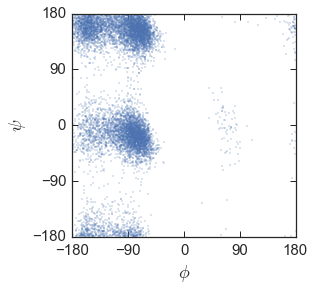

In [5]:
fig,ax = plt.subplots(figsize=(4,4))
ax.plot(180./math.pi*phi[1],180./math.pi*psi[1],'o', markersize=1)
ax.set_xlim(-180,180)
ax.set_ylim(-180,180)
ax.xaxis.set_ticks(range(-180,181,90))
ax.yaxis.set_ticks(range(-180,181,90))

ax.set_xlabel(r'$\phi$', fontsize=18)
ax.set_ylabel(r'$\psi$', fontsize=18)

Next we proceed to discretize the trajectory based on the Ramachandran angles.

In [6]:
tr.discretize(states=['A', 'E'])

For plotting we convert helical configurations in 1 and beta in 0.

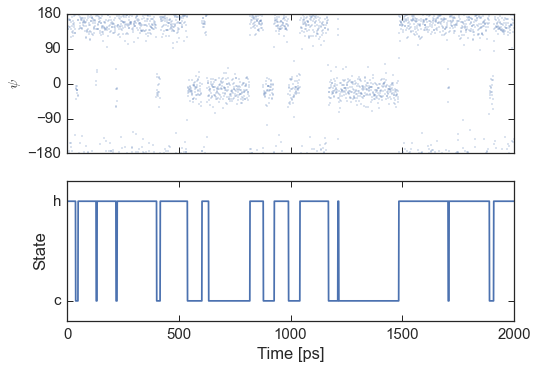

In [7]:
y = [0 if x == 'A' else 1 for x in tr.distraj]
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(psi[1]*180/math.pi,'o', markersize=1)
ax2.plot(y)

ax1.set_ylabel(r'$\psi$', fontsize=14)
ax1.set_xlim(0,2000)
ax1.set_ylim(-180,180)
ax1.yaxis.set_ticks(range(-180,181,90))

ax2.set_ylabel('State')
ax2.set_xlim(0,2000)
ax2.set_ylim(-0.2,1.2)
ax2.yaxis.set_ticks([0,1])
labels = [item.get_text() for item in ax2.get_xticklabels()]
labels[0] = 'c'
labels[1] = 'h'
ax2.set_yticklabels(labels)
ax2.set_xlabel('Time [ps]')

In the plot we see how we go from the time series of continuous torsion angles converts into a time series of discrete states. We can obtain a list of states in the following way.

In [8]:
tr.find_keys()
tr.keys
tr.file_name

['data/protein_only.xtc']

###Building the master equation model
After having loaded our trajectory using the functionalities from the `trajectory` module we start building the master equation model. For this, we make use of the `msm` module. There are two steps corresponding to the two main classes within that module. First we create an instance of the `SuperMSM`, which can be used to direct the whole process of constructing and validating the MSM.

In [9]:
from mastermsm.msm import msm
msm_alaTB = msm.SuperMSM([tr])


 Building MSM from 
[['data/protein_only.xtc']]
     # states: 2


Then, using the `do_msm` method, we produce instances of the `MSM` class. Each of these contains an MSM built at a specific lag time. These are stored as a dictionary in the `msms` attribute of the `SuperMSM` class. 

In [10]:
for i in [1, 2, 5, 7, 10, 20, 50, 100]:
    msm_alaTB.do_msm(i)
    msm_alaTB.msms[i].do_trans()
    msm_alaTB.msms[i].boots(plot=False)

Clearly, for lag times up to 5-10 ps the approximation is reasonable for the relaxation times (8 and 16% error, respectively), and it deteriorates rapidly. Equilibrium probabilities are recovered correctly at all lag times from the rate matrices.

###Validation
The two level structure that we have described, consisting of the `SuperMSM` and `MSM` classes, may look confusing. However, it allows for the user to test some global convergence properties first (at the level of the `SuperMSM`). 

####Convergence tests
For validating the model we first see at which point the relaxation times are sufficiently well converged.

In [11]:
msm_alaTB.convergence_test(time=[1, 2, 5, 7, 10, 20, 50, 100], error=True)

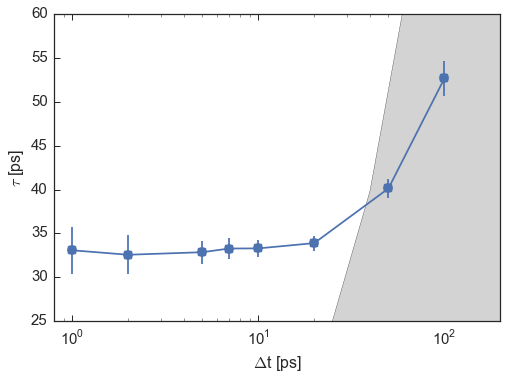

In [12]:
tau_vs_lagt = np.array([[x,msm_alaTB.msms[x].tauT[0],msm_alaTB.msms[x].tau_std[0]] \
               for x in sorted(msm_alaTB.msms.keys())])
fig, ax = plt.subplots()
ax.errorbar(tau_vs_lagt[:,0],tau_vs_lagt[:,1],fmt='o-', yerr=tau_vs_lagt[:,2], markersize=10)
#ax.plot(tau_vs_lagt[:,0],tau_vs_lagt[:,0])
ax.fill_between(10**np.arange(-0.2,3,0.2), 1e-1, 10**np.arange(-0.2,3,0.2), facecolor='lightgray')
ax.set_xlabel(r'$\Delta$t [ps]', fontsize=16)
ax.set_ylabel(r'$\tau$ [ps]', fontsize=16)
ax.set_xlim(0.8,200)
ax.set_ylim(25,60)
_ = ax.set_xscale('log')
#ax.set_yscale('log')

Here we see that from the very beginning the relaxation times are independent of the lag time ($\Delta$t) used in the construction of the model. This convergence is a good indicator of the Markovianity of the model and is a result of the use of transition based assignment. The shaded area corresponds to the range of lag times where the information we obtain is largely unreliable as the lag time is larger than the transition time.

####Chapman-Kolmogorov test
Another important step in the validation is to carry out is the so-called Chapman-Kolmogorov test. In this case, the MSM is validated against the simulation data used for its construction. 

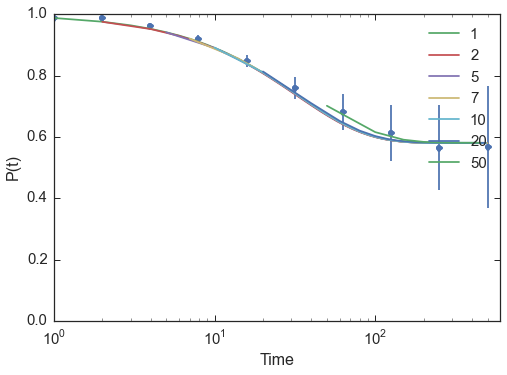

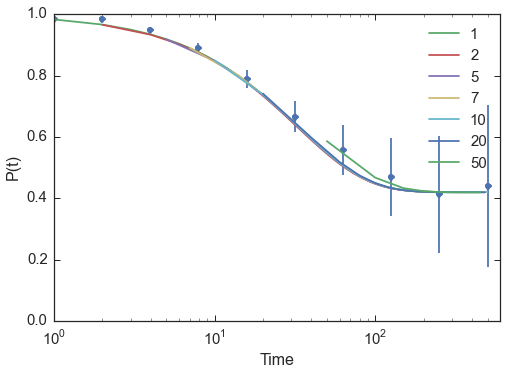

In [13]:
msm_alaTB.ck_test(time=[1, 2, 5, 7, 10, 20, 50], init=['E'])
msm_alaTB.ck_test(time=[1, 2, 5, 7, 10, 20, 50], init=['A'])

These plots show the decay of the population from a given initial condition. In this case the top and bottom plots corresponds to starting in the `E` and `A` basins respectively. In both cases we compare the calculation from the simulation data (as circles) and the propagation from MSMs calculated at different lag times (lines). As we could expect from the convergence analysis short lag times reproduce the simulation data well.

####Autocorrelation functions
The MSM can also be validated against the autocorrelation function (ACF) of the eigenmodes. If the simulation data is projected in the eigenmodes, then the ACF for mode $n$ should decay with a timescale equal to $-1/\lambda_n$. In this case there is only one mode to reproduce.

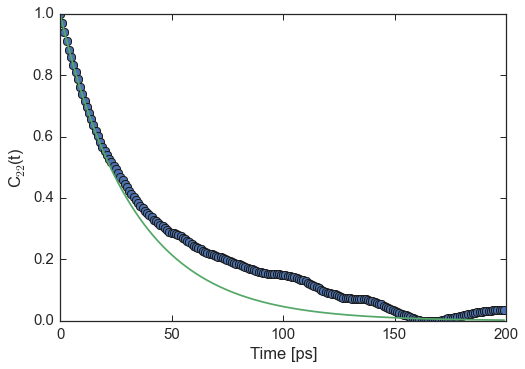

In [14]:
msm_alaTB.msms[2].do_trans(evecs=True)
self = msm_alaTB.msms[2]
kk = self.keep_keys
trajs = [[x.distraj, x.dt] for x in self.data]
lentr = 0
acf_ave = {}
x2 = []
dt = self.data[0].dt
for m in [1]:
    acf_cum = []
    for tr in trajs:
        projected = []
        for s in tr[0]:
            try:
                projected.append(self.lvecsT[kk.index(s),m])
            except ValueError:
                pass
        #        acf = np.array([x/(len(tr[0])-i) for i,x in enumerate(acf_half)])
        x2.extend([x**2 for x in projected])
        acf = np.correlate(projected, projected, mode='full')
        acf_half = acf[acf.size / 2:]
        acf_cum.append(acf_half)
    lmin = np.min([len(x) for x in acf_cum])
      
    acf_ave[m] = []
    for l in range(lmin):
        num = np.sum([x[l] for x in acf_cum])
        denom = np.sum([len(x)-l for x in acf_cum])
        acf_ave[m].append(num/denom)
    #    #        acf = np.array([x/(len(tr[0])-i) for i,x in enumerate(acf_half)])

    fig,ax = plt.subplots()
    nframes = 200
    time = np.arange(nframes)*dt
    ax.plot(time,acf_ave[m][:nframes]/np.mean(x2), 'o', mew=1, ms=8)
    ax.plot(time,np.exp(-time*1./self.tauT[0]))

    ax.set_xlim(0,200)
    ax.set_ylim(0,1)

    ax.set_xlabel('Time [ps]')
    ax.set_ylabel('C$_{22}$(t)')


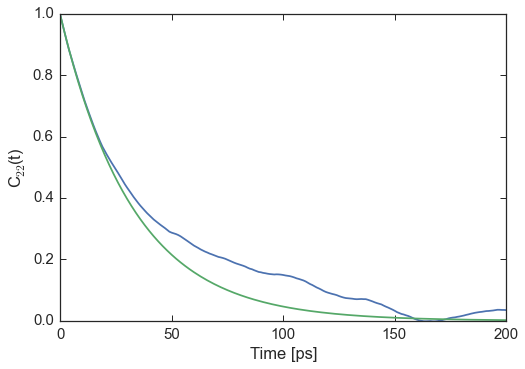

In [15]:
msm_alaTB.msms[2].do_trans(evecs=True)
acf = msm_alaTB.msms[2].acf_mode()
time = np.arange(len(acf[1]))*self.data[0].dt
fig, ax = plt.subplots()
ax.plot(time,acf[1])
ax.plot(time,np.exp(-time*1./msm_alaTB.msms[2].tauT[0]))

ax.set_xlim(0,200)
ax.set_ylim(0,1)

ax.set_xlabel('Time [ps]')
ax.set_ylabel('C$_{22}$(t)')

###Calculation of the rate matrix
From the transition matrix we can calculate the rate matrix. One possibility is to use an approximate method based simply on a Taylor expansion ([De Sancho, Mittal and Best, *JCTC*, 2013](http://dx.doi.org/10.1021/ct301033r)). We can check whether our approximate method gives a good result. We use short times since we have checked that short times are sufficient in this case for obtaining converged relaxation times.

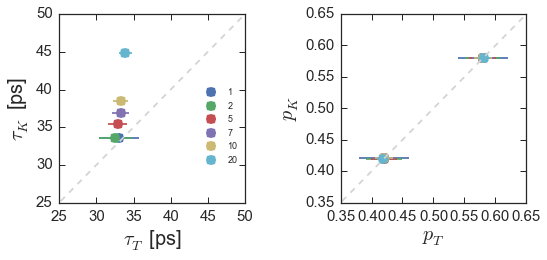

In [16]:
fig, ax = plt.subplots(1,2, figsize=(7.5,3.5))
for i in [1, 2, 5, 7, 10, 20]:
    msm_alaTB.msms[i].do_rate()
    ax[0].errorbar(msm_alaTB.msms[i].tauT, msm_alaTB.msms[i].tauK, fmt='o', xerr=msm_alaTB.msms[i].tau_std, markersize=10, label=str(i))
    ax[1].errorbar(msm_alaTB.msms[i].peqT, msm_alaTB.msms[i].peqK, fmt='o', xerr=msm_alaTB.msms[i].peq_std, markersize=10, label=str(i))

ax[0].plot([0,100],[0,100],'--', color='lightgray')
ax[0].set_xlabel(r'$\tau_T$ [ps]', fontsize=20)
ax[0].set_ylabel(r'$\tau_K$ [ps]', fontsize=20)
ax[0].set_xlim(25,50)
ax[0].set_ylim(25,50)

ax[1].plot([0.1,1],[0.1,1],'--', color='lightgray')
ax[1].set_xlabel(r'$p_T$', fontsize=20)
ax[1].set_ylabel(r'$p_K$', fontsize=20)
ax[1].set_xlim(0.35,0.65)
ax[1].set_ylim(0.35,0.65)

ax[0].legend(fontsize=9, bbox_to_anchor=(1.0, 0.65))
plt.tight_layout(pad=0.4, w_pad=3)